Binary Bank Competition - Kaggle


### Jupyter Notebook in VS Code

From directory with virtual environment in it, use this terminal command to use Jupyter Notebook in VS Code:

jupyter notebook --NotebookApp.allow_origin='*' --NotebookApp.ip='0.0.0.0'

### Select Python Interpreter

Open Command Palette as follows: Ctrl+Shift+P

Then select from VS Code Command Palette: "Python: Select Interpreter" and choose the same Python interpreter that you used to install Jupyter.

If server not shown, enter server manually as follows: 
http://localhost:8888

Reminder:  pw: ""

In [30]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from stepbystep_v0 import StepByStep

# Binary Classification Problem based on Bank Customer Marketing Call Data

## Data Loading

In [ ]:
# Import data from .csv file
raw_data = pd.read_csv('binary_bank_comp/dataset/train.csv')

# Display the first few rows of the dataset
print(raw_data[:5])

   id  age          job  marital  education default  balance housing loan  \
0   0   42   technician  married  secondary      no        7      no   no   
1   1   38  blue-collar  married  secondary      no      514      no   no   
2   2   36  blue-collar  married  secondary      no      602     yes   no   
3   3   27      student   single  secondary      no       34     yes   no   
4   4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1  
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' '

## Split the dataset

In [3]:
# Remove id column
raw_data.drop(columns=['id'], inplace=True)

# Split the dataset into features and target variable
X = raw_data.drop(columns=['y'])
y = raw_data['y']

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

# Print the first few rows of the training set
print("Training set preview:")
print(X_train.head())
print(y_train.head())

Training set shape: (600000, 16) (600000,)
Validation set shape: (150000, 16) (150000,)
Training set preview:
        age          job   marital  education default  balance housing loan  \
453635   28  blue-collar    single  secondary      no     5090     yes  yes   
11651    51   technician   married   tertiary      no     1295      no   no   
431999   57   management  divorced   tertiary      no        0      no   no   
529211   48  blue-collar    single    primary      no     1323     yes   no   
110925   38       admin.   married  secondary      no      659     yes   no   

         contact  day month  duration  campaign  pdays  previous poutcome  
453635   unknown   12   may      1297         2     -1         0  unknown  
11651   cellular   27   aug       119         9     -1         0  unknown  
431999  cellular   29   jan        87         1     -1         0  unknown  
529211   unknown   15   may        83         5     -1         0  unknown  
110925  cellular   28   jul       5

## Data Cleaning

In [4]:
# Clean the dataset

# Identify numerical columns (excluding the target and any non-feature columns)
X_train_num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_val_num_cols = X_val.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns
X_train_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_val_categorical_cols = X_val.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert categorical features to numerical using one-hot encoding using 1s and 0s
X_train = pd.get_dummies(X_train, columns=X_train_categorical_cols, drop_first=False).astype(int)
X_val = pd.get_dummies(X_val, columns=X_val_categorical_cols, drop_first=False).astype(int)

# Standardize numerical features from 0 to 1
X_train[X_train_num_cols] = X_train[X_train_num_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_val[X_val_num_cols] = X_val[X_val_num_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Show the cleaned dataset
print(X_train.head())
print(X_val.head())

             age   balance       day  duration  campaign  pdays  previous  \
453635  0.129870  0.121677  0.366667  0.263575  0.016129    0.0       0.0   
11651   0.428571  0.086452  0.866667  0.023998  0.129032    0.0       0.0   
431999  0.506494  0.074432  0.933333  0.017490  0.000000    0.0       0.0   
529211  0.389610  0.086712  0.466667  0.016677  0.064516    0.0       0.0   
110925  0.259740  0.080549  0.900000  0.108399  0.048387    0.0       0.0   

        job_admin.  job_blue-collar  job_entrepreneur  ...  month_jun  \
453635           0                1                 0  ...          0   
11651            0                0                 0  ...          0   
431999           0                0                 0  ...          0   
529211           0                1                 0  ...          0   
110925           1                0                 0  ...          0   

        month_mar  month_may  month_nov  month_oct  month_sep  \
453635          0          1     

## Data Preparation

In [5]:
torch.manual_seed(13)

# Convert pandas DataFrames to Numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
x_val_tensor = torch.as_tensor(X_val).float()
# Reshapes y_train and y_val to be column vectors
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)


## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + ... + w_nx_n + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2 + ... + w_nx_n
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [6]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [7]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

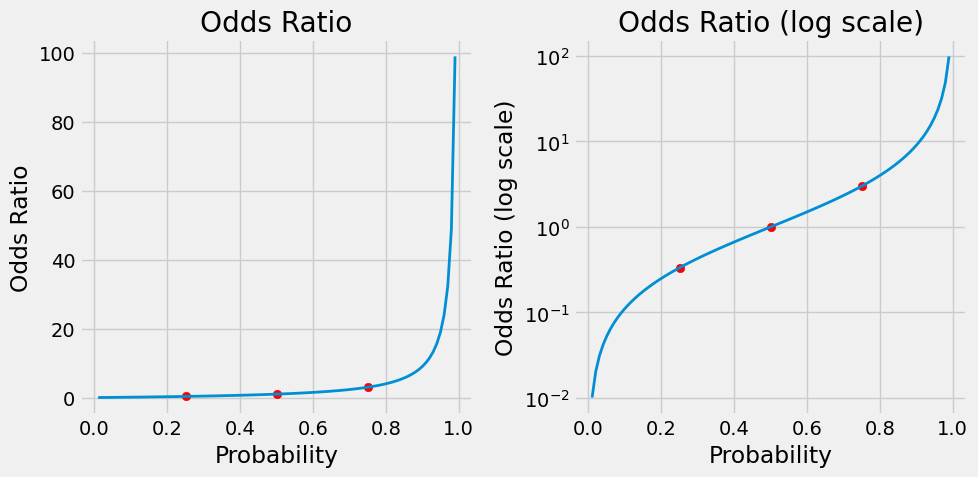

In [8]:
def odds(prob):
    return prob / (1 - prob)

def figure2(prob1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    prob = np.linspace(.01, .99, 99)

    for i in [0, 1]:
        ax[i].plot(prob, odds(prob), linewidth=2)
        ax[i].set_xlabel('Probability')
        if i:
            ax[i].set_yscale('log')
            ax[i].set_ylabel('Odds Ratio (log scale)')
            ax[i].set_title('Odds Ratio (log scale)')
        else:
            ax[i].set_ylabel('Odds Ratio')
            ax[i].set_title('Odds Ratio')
        ax[i].scatter([prob1, .5, (1-prob1)], [odds(prob1), odds(.5), odds(1-prob1)], c='r')

    fig.tight_layout()
    
    return fig


fig = figure2(p)

### Log Odds Ratio

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [9]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(np.float64(1.0986122886681098), np.float64(-1.0986122886681098))

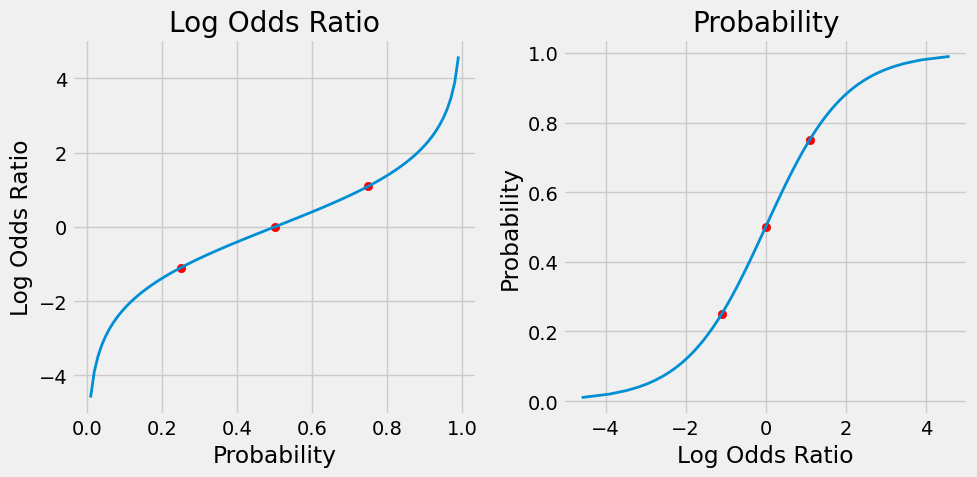

In [10]:
def log_odds(prob):
    return np.log(odds(prob))

def figure3(prob1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    prob = np.linspace(.01, .99, 99)

    ax[0].plot(prob, log_odds(prob), linewidth=2)
    ax[0].set_xlabel('Probability')
    ax[0].set_ylabel('Log Odds Ratio')
    ax[0].set_title('Log Odds Ratio')
    ax[0].scatter([prob1, .5, (1-prob1)], [log_odds(prob1), log_odds(.5), log_odds(1-prob1)], c='r')

    ax[1].plot(log_odds(prob), prob, linewidth=2)
    ax[1].set_ylabel('Probability')
    ax[1].set_xlabel('Log Odds Ratio')
    ax[1].set_title('Probability')
    ax[1].scatter([log_odds(prob1), log_odds(.5), log_odds(1-prob1)], [prob1, .5, (1-prob1)], c='r')
    fig.tight_layout()

    return fig

fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 + ... + w_nx_n = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2 + ... + w_nx_n} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(np.float64(0.75), np.float64(0.25))

### Sigmoid

In [12]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

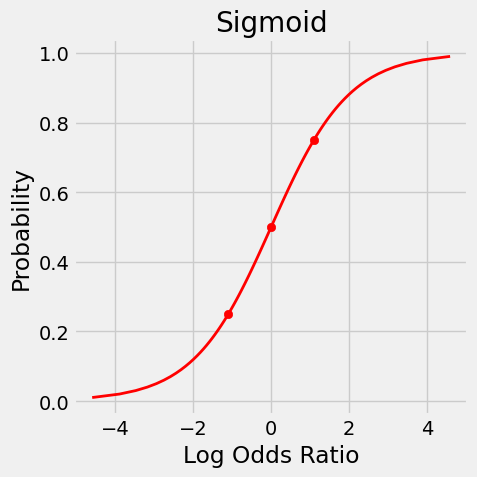

In [13]:
def figure4(prob1):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    prob = np.linspace(.01, .99, 99)

    ax.plot(log_odds(prob), prob, linewidth=2, c='r')
    ax.set_ylabel('Probability')
    ax.set_xlabel('Log Odds Ratio')
    ax.set_title('Sigmoid')
    ax.scatter([log_odds(prob1), log_odds(.5), log_odds(1-prob1)], [prob1, .5, (1-prob1)], c='r')
    fig.tight_layout()

    return fig

fig = figure4(p)

### Logistic Regression

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2 + ... + w_nx_n) = \frac{1}{1+e^{-(b+w_1x_1+w_2x_2 + ... + w_nx_n)}}      
$$

![](images/logistic_model.png)

In [14]:
torch.manual_seed(42)
feature_cnt = X_train.shape[1]
print("Number of features:", feature_cnt)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(feature_cnt, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

Number of features: 51
OrderedDict({'linear.weight': tensor([[ 0.1071,  0.1162, -0.0328,  0.1286, -0.0307,  0.0283, -0.0682,  0.0822,
          0.1234, -0.1027,  0.1217,  0.0262,  0.1035,  0.0190,  0.0675, -0.0198,
          0.1079,  0.0207, -0.0654,  0.0357, -0.0645, -0.0164, -0.0569,  0.0929,
         -0.1105, -0.0646, -0.0395, -0.0842,  0.0132, -0.1383,  0.1265, -0.1189,
          0.1081,  0.0233, -0.0455,  0.0865,  0.0218,  0.1131,  0.0153, -0.0442,
          0.0376, -0.0380,  0.0589,  0.1250,  0.0809, -0.0612,  0.0808,  0.0251,
          0.0711, -0.0853, -0.1386]]), 'linear.bias': tensor([-0.0541])})


### A Note on Notation (for reference)

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In [15]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [16]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [17]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

In [18]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

In [19]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [20]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [21]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

## Model Configuration

In [22]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
feature_cnt = X_train.shape[1]
print("Number of features:", feature_cnt)
model = nn.Sequential()
model.add_module('linear', nn.Linear(feature_cnt, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

Number of features: 51


## Model Training

In [23]:
n_epochs = 40

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('run1', folder='binary_bank_comp/runs')
sbs.train(n_epochs)

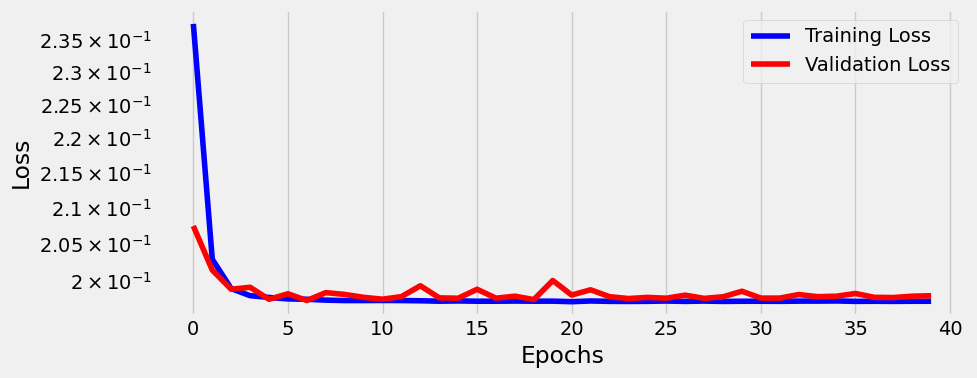

In [24]:
fig = sbs.plot_losses()

In [25]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[-2.1237e-01,  3.4613e+00,  7.1410e-02,  2.7223e+01, -9.2346e+00,
         -3.3723e+00,  6.5835e-01,  9.9428e-02, -2.3251e-01, -3.0387e-01,
         -4.1036e-01,  9.7245e-02,  5.1428e-01, -1.9493e-01, -1.5768e-01,
          6.5904e-01,  2.2581e-02, -2.6380e-01, -2.4175e-01, -3.8010e-01,
         -4.2421e-01, -1.3754e-01, -4.8328e-01, -2.0547e-01,  2.8600e-02,
         -3.7553e-01, -5.3444e-01, -4.8589e-01, -7.3812e-02, -9.4788e-01,
         -1.3396e-01, -7.5514e-01,  4.6306e-01,  1.3606e-01, -1.4098e+00,
         -1.0177e-01, -8.6455e-01,  4.6853e-01, -1.9347e-01, -1.4122e+00,
         -1.0760e+00,  3.3972e-01,  2.0214e+00, -2.0226e-01, -1.1686e+00,
          9.2289e-01,  8.4654e-01, -7.0394e-01, -7.9837e-01,  2.0470e+00,
         -1.5690e+00]], device='cuda:0'), 'linear.bias': tensor([-0.9507], device='cuda:0')})


In [37]:
# Save model
sbs.save_checkpoint(filename='binary_bank_comp/checkpoint.pth')

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2 + ... + w_nx_n
\\
z & = & -0.9507 & - & 0.21237x_1 & - & 3.4613x_2 + ... + w_nx_n
\end{array}
$$

#### Making Predictions (Logits)

In [26]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.5013724],
       [-4.304551 ],
       [-3.7724526],
       [-6.4923754]], dtype=float32)

#### Making Predictions (Probabilities)

In [27]:
probabilities = sigmoid(predictions)
probabilities

array([[0.6227818 ],
       [0.01332694],
       [0.02247868],
       [0.00151265]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [28]:
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [0],
       [0],
       [0]])

## Decision Boundary

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

In [31]:
def figure7(X, y, model, device, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(15, 4.5))

    h = .02  # step size in the mesh

    # x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    # y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    
    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    # 1st plot
    ax = plt.subplot(1, 3, 1)

    contour = ax.contourf(xx, yy, logits, 25, cmap=cm, alpha=.8)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$z = b + w_1x_1 + w_2x_2$')
    ax.grid(False)
    ax_c = plt.colorbar(contour)
    ax_c.set_label("$z$", rotation=0)

    # 2nd plot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    surf = ax.plot_surface(xx, yy, yhat, rstride=1, cstride=1, alpha=.5, cmap=cm, linewidth=0, antialiased=True, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')

    ax_c = plt.colorbar(surf)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax.view_init(30, 220)

    # 3rd plot
    ax = plt.subplot(1, 3, 3)

    ax.contour(xx, yy, yhat, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])

    plt.tight_layout()
    
    return fig

# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50625x2 and 51x1)

<Figure size 1500x450 with 0 Axes>

In [32]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50625x2 and 51x1)

<Figure size 1500x450 with 0 Axes>

### Are my data points separable?

In [33]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

NameError: name 'one_dimension' is not defined

$$
\Large X_2 = f(X_1)= X_1^2
$$

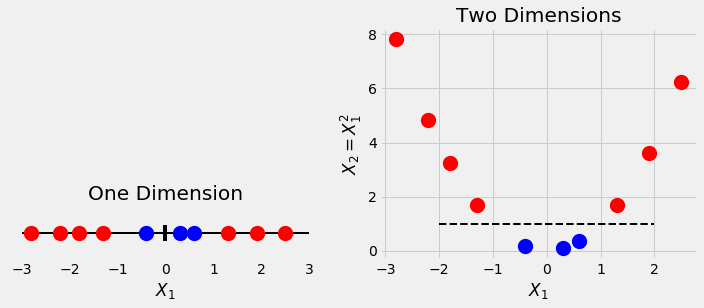

In [38]:
fig = two_dimensions(x, y)

In [39]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold

In [34]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50625x2 and 51x1)

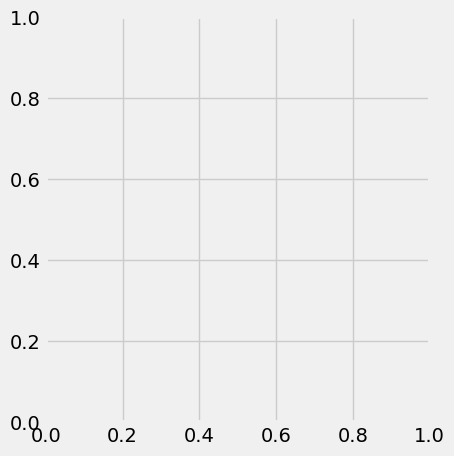

In [36]:
def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax

def probability_contour(ax, model, device, X, y, threshold, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    h = .02  # step size in the mesh

    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    ax.contour(xx, yy, yhat, levels=[threshold], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    return ax

def figure9(x, y, model, device, probabilities, threshold, shift=0.0, annot=False, cm=None, cm_bright=None):
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(3, 3)

    ax = fig.add_subplot(gs[:, 0])
    probability_contour(ax, model, device, x, y, threshold, cm, cm_bright)
    
    if cm_bright is None:
        colors = ['r', 'b']
    else:
        colors = cm_bright.colors

    ax = fig.add_subplot(gs[1, 1:])
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)

    fig.tight_layout()
    return fig

fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

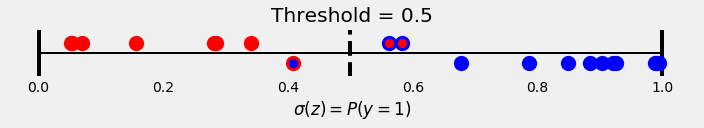

In [42]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

### Confusion Matrix

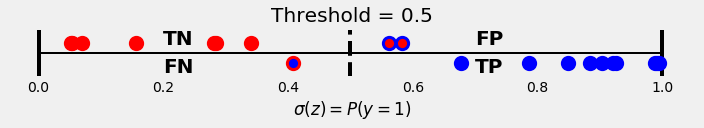

In [43]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [44]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

#### True and False Positives and Negatives

In [45]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [46]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [47]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [48]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [49]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

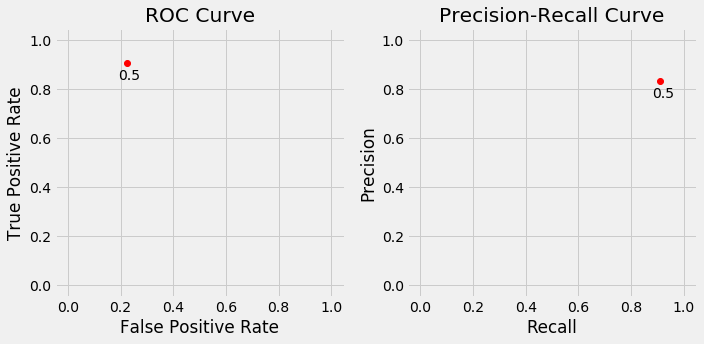

In [50]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

### Low Threshold

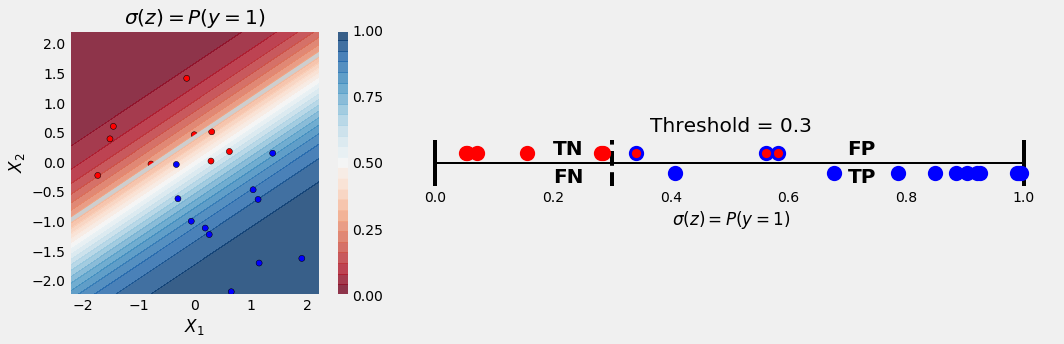

In [51]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

In [52]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

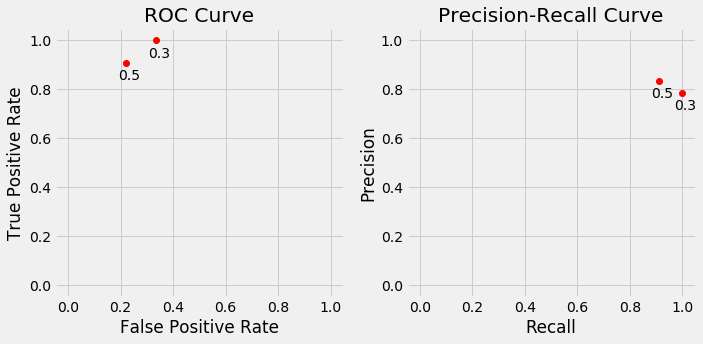

In [53]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

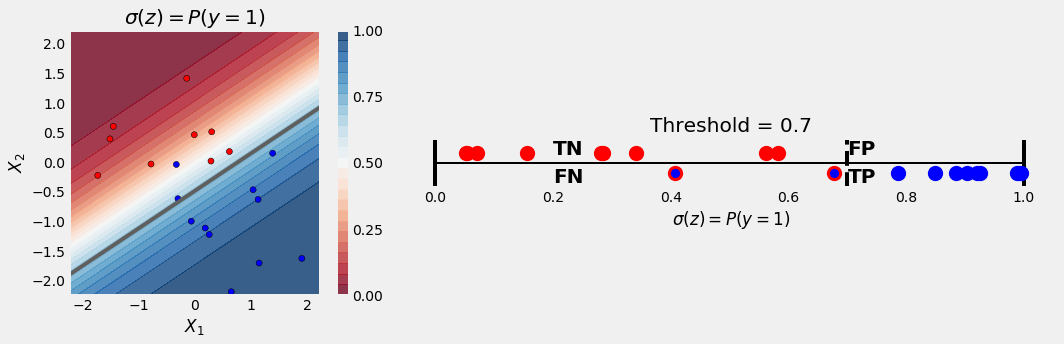

In [54]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [55]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

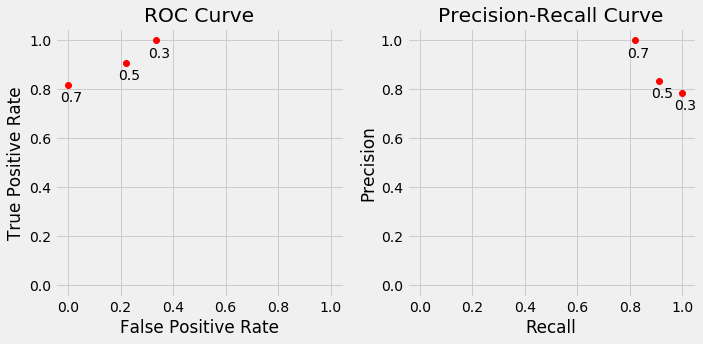

In [56]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [57]:
threshs = np.linspace(0.,1,11)

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


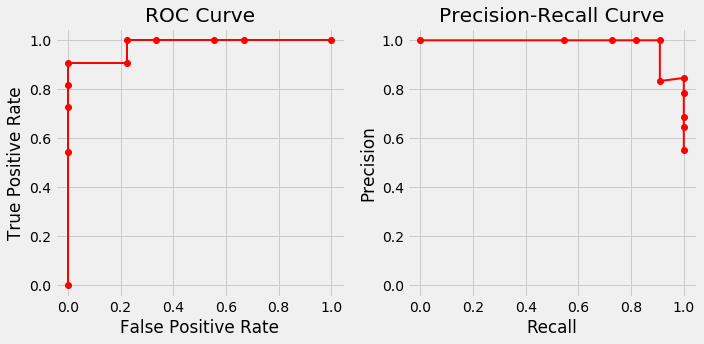

In [58]:
fig = figure17(y_val, probabilities_val, threshs)

In [59]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

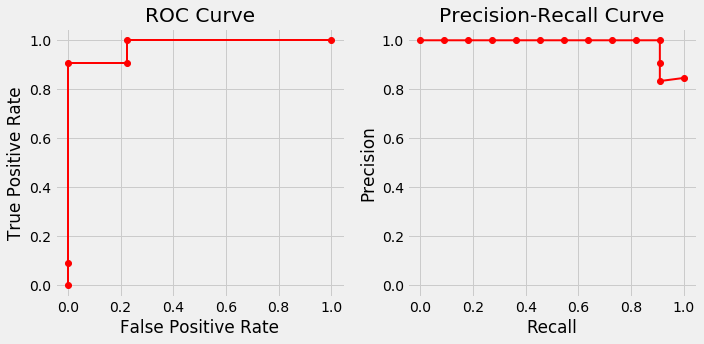

In [60]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

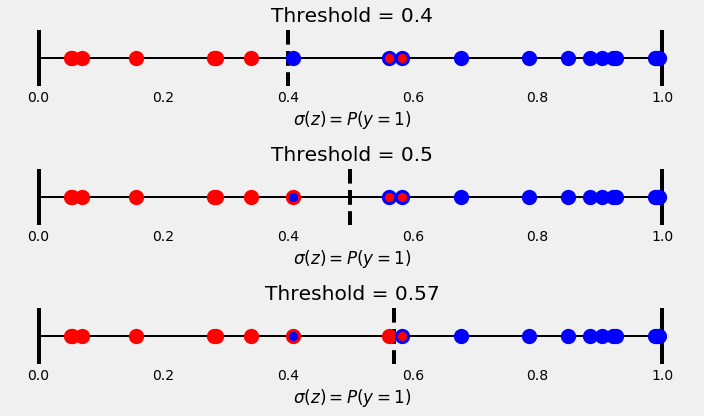

In [61]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

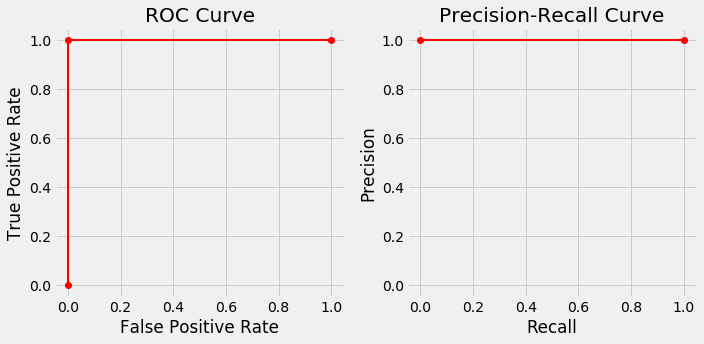

In [62]:
# Best
fig = figure20(y_val)

In [63]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [64]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

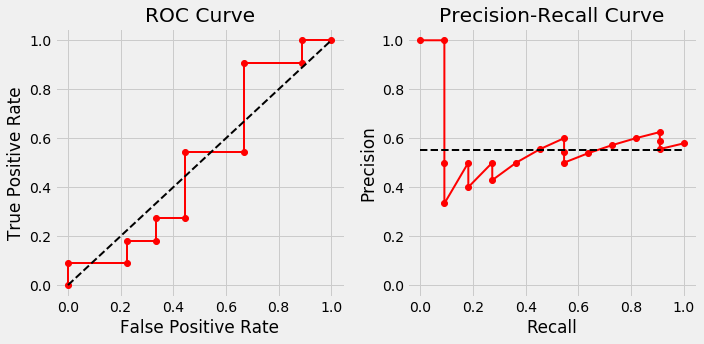

In [65]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [66]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [67]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [68]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [69]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [70]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [71]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1822, -1.8684]], device='cuda:0')), ('linear.bias', tensor([-0.0587], device='cuda:0'))])


In [72]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])